# Carl's list: Chandra data


When I started working on the ages program, I realized that I needed exactly the same code as in here. However, I did not want to dublicate everything, so I started to pull it out into utils.py and chandra_helpers.py. In doing so, I changes som of the signatures or the naming convention for columns in the main table. I now need to go back and use those noew fucntiosn in this notebook, too, which will probably lead to a minor re-porganizaiton in some cases.
 


## Top level summary
This is text for us, not for a paper. For the paper, I will add some more details of what I tried and what the size of the extraction regions where etc, but here is my top-level summary of what we can learm from the Chandra part of that dataset.

### Grating spectra

- $\eta$ Lep: This is discussed in much detail in [Wood et al (2008)](https://ui.adsabs.harvard.edu/2018ApJ...862...66W):
  The paper has detailed abundances, temperatures, and lots of discussion on temperature and FIP/IFIP. It's the only useful grating data in the list, so it's processed in a very different way from all the other datasets, so there is little use in saying "We reprocessed it to make sure it's all done in the same way". I decided not not fit this myself, instead we should just take [Wood et al (2008)](https://ui.adsabs.harvard.edu/2018ApJ...862...66W) for our discussion.
- Altair: This spectrum is pretty noisy and thus useless. There are some clear emission lines that are visible and are not hard to reproduce with a cool model. Really, I only see the O VII and O VIII lines, everything else is compatible with noise. That is much less information than Robrade et al. (2009) get from their XMM observation; so there is no use in reprocessing that.
- 10 Tau: Happens to be close to HR1099, which is a regular target for calibration. However, in all of those observations 10 Tau is far off-axis where the PSF is bad and it's taken with HRC-S which has a high background, so those observations are no use to us.

### Imaging

This includes ACIS and HRC observations. Some of those are previously published, but for simplictiy, I just run them all through the same script here. For a publication, we could consider to only present those datases where the source we are interested in has not been previously published. There are a few special observing setups in the list that might be easier to cite than to discuss again.

- Vega: Frequently observed to study the UV/optical light leak. No X-rays seen. Detailed discussion in [Pease et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...636..426P/abstract). Since this discussion is somewhat technical to proove that all apparent photons are really UV and optical leaks, I suggest to take the number from the paper. No use in re-doing their analysis.

- $\tau$ Ceti: There are two observation. The more useful one is taken with ACIS, but there is also an HRC in the special dither mode to dither the source on and off the different filter thickness. Standard processing can only give a count number, but that's not very helpful. This will need special processing if we want to use it. It's a relatively new observation by Steeve Saar that became public just a few months ago, and there is no publication about it yet.
I suggest that we contact Steeve and ask for the status and his plans. Maybe he has a publication in progress; then we could just take his number and cite him. Or, we could ask him to do the analysis and join this publication if he thinks a stand-alone article is not warranted. Either way, I would not have to deal with this unusual setup. (I can, but if he's doing that anyway, why should I duplicate the work?). 

- The remaining observations consist of the mix of ACIS and HRC. Most sources are undetected. I can put an upper limit on counts, but to convert that to an upper limit on energy flux (which is more useful for physics), I need to assume some physical model. CHOOSE MODEL! See table for flux limits.

- HD 166191 and $\beta$ Pic are detected. We have published $\beta$ Pic before, for HD 166191 I can make a crude spectrum and find XXXXX. HD166191 is almost exactly on the edge of the chip, it dithers on an off during the observations. 


### Notable papers based on the ObsIDs I'm using below
This is not a complete list, but just some notes of papers we might want to cite as I come across them

- Formalhaut: [Poppenhaeger et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.468.4018P/abstract). THey claim  $L_X <6.3×10^{24}$ erg/s in 0.2--2 keV band.

In [1]:
import glob
import os
import sys

import astropy
from astropy.table import Table
from astropy import table
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import MaxNLocator
from astropy.visualization.wcsaxes import SphericalCircle

from ciao_contrib.region.check_fov import FOVFiles
from ciao_contrib import runtool as rt
from coords.chandra import cel_to_chandra
from ciao_contrib.psf_contrib import psfSize
from sherpa.astro import ui

import utils
import chandra_helpers
import model_helpers

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


In [2]:
targets = table.Table.read('Astars.txt', 
                          format='ascii.no_header', names=['object'], 
                          # Default is to fail if there is only one column in guessing.
                          guess=False, delimiter=',')

Coordinates are complex objects which include proper motions and parallaxes. We first build up a structure to save those coordiantes, so that we have to query Simbad only once.

In [3]:
coords = utils.coords_from_simbad(targets['object'], 
                                  'data/A_stars/simbad.ecsv')

In [4]:
chandra_obs = chandra_helpers.search_chandra_archive(coords, 'data/A_stars/obsids.ecsv')

Vega is regularly observed with the HRC as a calibration target to calibrate the optical/UV light leak. Since we are interested in the X-ray properties of our target stars, these observations are not useful to us. There are also three observations listed with zero exposure time, which we also exclude.

In [5]:
vegacal = (chandra_obs['object'] == 'Vega') & \
    ((chandra_obs['Instrument'] == 'HRC-I') | (chandra_obs['Instrument'] == 'HRC-S'))
chandra_obs = chandra_obs[~vegacal & (chandra_obs['Exposure'] > 0)]

In [6]:
chandra_obs

ObsId,obs_date,RA,Dec,Instrument,Exposure,Grating,object
int64,str19,float64,float64,str6,float64,str4,str9
24965,2021-02-26T07:32:00,46.22156,-7.6824,ACIS-S,24.26,NONE,10 Eri
1008,2000-12-14T14:43:00,54.1970833333333,0.589972222222222,HRC-I,1.49,NONE,10 Tau
1115,1999-09-02T11:22:00,54.197083,0.589972,HRC-I,1.78,NONE,10 Tau
1138,1999-09-03T07:04:00,54.197083,0.589972,HRC-I,0.79,NONE,10 Tau
1139,1999-09-03T07:34:00,54.197083,0.589972,HRC-I,0.79,NONE,10 Tau
1140,1999-09-03T08:04:00,54.197083,0.589972,HRC-I,0.79,NONE,10 Tau
1142,1999-09-03T09:04:00,54.197083,0.589972,HRC-I,0.79,NONE,10 Tau
1143,1999-09-03T09:34:00,54.197083,0.589972,HRC-I,0.79,NONE,10 Tau
1144,1999-09-03T10:04:00,54.197083,0.589972,HRC-I,0.79,NONE,10 Tau


Another targets that is observed a lot is 10 Tau with the HRC-I, because it falls in the field of HR 1099, which is used to calibrate the HRC PSF. Because 10 Tau is very faint, it cannot be detected in the individual observations, but we will try below to stack all those observations together. When we do that, we'll have to decide if we only use HRC-I observations or if we want to include HRC-S observations, which have a higher background.

In [7]:
HR1099_cals_with_10Tau = (chandra_obs['object'] == '10 Tau') & \
    ((chandra_obs['Instrument'] == 'HRC-I') |(chandra_obs['Instrument'] == 'HRC-S'))
print('Number of HR1099 HRC calibrations:', HR1099_cals_with_10Tau.sum())

Number of HR1099 HRC calibrations: 51


In [8]:
obs_to_look_at = chandra_obs[~HR1099_cals_with_10Tau]

In [9]:
grating = obs_to_look_at['Grating'] != 'NONE'
print(f'Of the remaining {len(obs_to_look_at)} observations, {grating.sum()} are grating observations.')

Of the remaining 28 observations, 5 are grating observations.


In [10]:
obs_to_look_at[grating]

ObsId,obs_date,RA,Dec,Instrument,Exposure,Grating,object
int64,str19,float64,float64,str6,float64,str4,str9
1252,1999-09-17T12:42:00,54.197083,0.589972,ACIS-S,14.75,HETG,10 Tau
62538,1999-09-14T22:53:00,54.1970833333333,0.589972222222222,ACIS-S,94.69,HETG,10 Tau
11015,2009-08-26T15:19:00,297.697083333333,8.86927777777778,HRC-S,92.87,LETG,Altair
20130,2017-12-15T21:11:00,89.10125,-14.1676944444444,HRC-S,116.26,LETG,eta Lep
20884,2017-12-11T17:02:00,89.10125,-14.1676944444444,HRC-S,38.05,LETG,eta Lep


Two of those (those with 10 Tau) are really observations of HR1099, so we first want to check if our target 10 Tau is actually in the field of view and cleanly visible and not, e.g., coincident with of the dispersed spectra from the brighter target.

In [11]:
# In some cases, it will later turn out that the objects of interest is not
# in the FOV, so we could save the time of reprocessing, but it does not take
# that long, so we will just reprocess everything.
chandra_helpers.download_repro('data/A_stars', chandra_obs['ObsId'])

KeyboardInterrupt: 

An interactive check shows that 10 Tau is indeed in the field of view and almost certaily undetected. That means that, for our purposes here, we treat these observations like imageing observations with very short (because the gratings are inserted and thus only a small fraction of the zero-order photons makes it through to a direct image) normal imaging observations. 

The two LETGS observations of eta Lep are already discussed in great detail in [Wood et al (2008)](https://ui.adsabs.harvard.edu/2018ApJ...862...66W), so there is little use in re-analysing them here. For the imaging observations, I will download and treat them all, incl. the already published ones, because that can serve as a cross-check and for consistency in applying the newest calibration etc. to all of them, but grating observations are different anyway. That leaves ObsID 11015 from Altair, which Jan Robrade observed in 2009 and did not publish yet. The original motivation was to measure line broadening due to the fast rotation, but as it turns out, the spectrum is faint and pretty noisy, so constraining the line broadening with this data is out of the question. One can see a few individual lines and fit a plasma model, but there is not much to be learned that's not already seen in the XMM imaging observation from [Robrade et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...497..511R%2F/abstract). However, since it's unpublished, Jan likely won't mind to finally get it out there - we should probably invite him anyway-, and I work for Chandra and hate to see data forgotten in the archive, I will take it anyway. Instead of reducing the gratings data by myself, I download it manually from http://tgcat.mit.edu/, and will fit and make a few plots now before I turn to the imaging data.

In [12]:
utils.coords_for_obs(chandra_obs, coords)

## The grating spectrum of Altair

In [10]:
ui.load_data(id=11015, filename='data/A_stars/tgcat/obs_11015_tgid_3118/pha2.gz')
orders = list(range(1, 9))
ui.load_multi_arfs(id=11015, 
                   filenames=[f'data/A_stars/tgcat/obs_11015_tgid_3118/leg_-{o}.arf.gz' for o in orders],
                   resp_ids=orders)
ui.load_multi_rmfs(id=11015, 
                   filenames=[f'data/A_stars/tgcat/obs_11015_tgid_3118/leg_-{o}.rmf.gz' for o in orders],
                   resp_ids=orders)

ui.load_multi_arfs(id=11016, 
                   filenames=[f'data/A_stars/tgcat/obs_11015_tgid_3118/leg_{o}.arf.gz' for o in orders],
                   resp_ids=orders)
ui.load_multi_rmfs(id=11016, 
                   filenames=[f'data/A_stars/tgcat/obs_11015_tgid_3118/leg_{o}.rmf.gz' for o in orders],
                   resp_ids=orders)

statistical errors were found in file 'tgcat/obs_11015_tgid_3118/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background file tgcat/obs_11015_tgid_3118/pha2_bg
read background_up into a dataset from file tgcat/obs_11015_tgid_3118/pha2.gz
read background_down into a dataset from file tgcat/obs_11015_tgid_3118/pha2.gz
Multiple data sets have been input: 11015-11016


In [14]:
ui.set_analysis('wave')
ui.notice(5, 25)  # in Agstroem. Is about 0.5 to 2 keV.

In [15]:
ui.set_stat('chi2gehrels')

In [16]:
ui.subtract(id=11015)
ui.subtract(id=11016)

In [17]:
ui.set_source(id=11015, model=ui.xsvapec.v1 + ui.xsvapec.v2)
# Now set the exact same model for the other side of the spectrum
ui.set_source(id=11016, model=v1 + v2)

In [18]:
#first ionization potential
#set oxygen as the standard
v1.O = 1
v1.O.frozen = True
#OCNS smilar
v1.C = v1.O
v1.N = v1.O
v1.S = v1.O
v1.Ar = v1.O
#Ni, Mg, Fe, Si, Al, Ca are < 10 eV, similar
v1.Ni = v1.Fe
v1.Mg = v1.Fe
v1.Si = v1.Fe
v1.Al = v1.Fe
v1.Ca = v1.Fe
v1.Fe.frozen = False #frozen by default
#Ne is high and it's own group
v1.Ne.frozen = False
v1.He=v1.Ne

In [19]:
#model setting for 2T
for p1, p2 in zip(v1.pars[1:-1], v2.pars[1:-1]):
    #use [1:-1] to NOT link the temperature and the norm (first and last parameter) because we want to fit those separately!
    p2.link = p1

In [20]:
# Since I subtracted the background, I have to bin
ui.group_counts(id=11015, num=15)
ui.group_counts(id=11016, num=15)

ui.fit(11015, 11016)

Reading APEC data from 3.0.9

Datasets              = 11015, 11016
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 3.38966e+08
Final fit statistic   = 388.347 at function evaluation 178
Data points           = 605
Degrees of freedom    = 599
Probability [Q-value] = 1
Reduced statistic     = 0.648326
Change in statistic   = 3.38966e+08
   v1.kT          0.0904243    +/- 0.0653867   
   v1.Ne          6.18938      +/- 36.5545     
   v1.Fe          0            +/- 170.338     
   v1.norm        0.000663408  +/- 0.00252073  
   v2.kT          4.82118      +/- 0           
   v2.norm        0            +/- 7.2599e-05  


In [21]:
# This runs forever, maybe it even hangs. Can investigate if we need it later. 
# ui.plot_energy_flux(.2, 2., id=11015)

In [22]:
Fx = ui.calc_energy_flux(.2, 2., id=11015) * u.erg/u.s/u.cm**2
Lx = Fx * (4 * np.pi * (5.1 * u.pc)**2)
Lx.to(u.erg/u.s)

<Quantity 0. erg / s>

(11.0, 25.0)

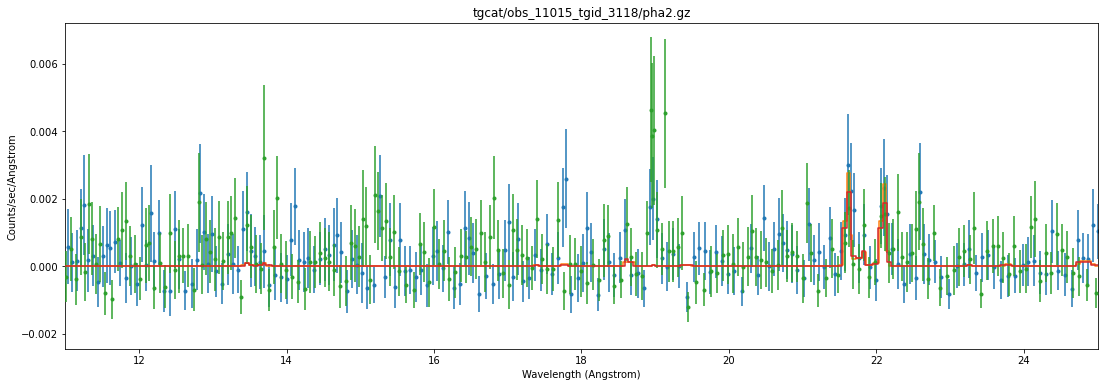

In [23]:
#ui.group_counts(id=26222, num=15)
ui.set_analysis('wave')
ui.plot_fit(11015) #, color='black')
ui.plot_fit(11016, overplot=True) #, color='red')

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
fig.axes[0].set_xlim(11, 25.)

This spectrum is pretty noisy. There are some clear emission lines that are visible and are not hard to reproduce with a cool model. Really, I only see the O VII and O VIII lines, everything else is compatible with noise. That is much less information than [Robrade et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...497..511R%2F/abstract) get from their XMM observation. The fittted temperatures are compatible, I can make a 2T model lock-in to two of their temperatures. I'm sure I could also fit a 3T model, but that's really not jutified for this spectrum. In XMM it's $L_X$ was 1.4e27, about twice as much as I observe here. 

## The calibration observations of HR 1099 which include 10 Tau

As it turns out below, not that much of this data is actually useful. So is it worth the effort? In hind-sight, probably not, but I did not know that when I started this analysis, so I leave it here even if it's not helpful.

In [13]:
print('HR1099 HRC-S observations: ', (chandra_obs[HR1099_cals_with_10Tau]['Instrument'] == 'HRC-S').sum())

HR1099 HRC-S observations:  1


In [14]:
print('HR1099 HRC-I observations with gratings: ', (chandra_obs[HR1099_cals_with_10Tau]['Grating'] != 'NONE').sum())

HR1099 HRC-I observations with gratings:  5


In [15]:
chandra_obs[(chandra_obs['object'] == '10 Tau') & (chandra_obs['Grating'] != 'NONE')][chandra_obs.colanmes[:-1]]

ObsId,obs_date,RA,Dec,Instrument,Exposure,Grating,object,coord
int64,str19,float64,float64,str6,float64,str4,str9,object
1252,1999-09-17T12:42:00,54.197083,0.589972,ACIS-S,14.75,HETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.21828418, 0.40170327, 13.92040314)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.5630011, -481.47199947, -2.6537261e-05)>"
1388,1999-10-27T13:23:00,54.197083,0.589972,HRC-I,2.26,LETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.2182771, 0.40168862, 13.92040314)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.56300069, -481.47199967, -1.65132314e-05)>"
1392,1999-10-27T14:56:00,54.197083,0.589972,HRC-I,2.26,LETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.21827709, 0.40168859, 13.92040314)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.56300069, -481.47199967, -1.64970583e-05)>"
1393,1999-10-27T15:43:00,54.197083,0.589972,HRC-I,2.26,LETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.21827708, 0.40168858, 13.92040314)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.56300069, -481.47199967, -1.64888848e-05)>"
1879,2001-01-10T23:13:00,54.1970833333333,0.58775,HRC-S,94.89,LETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.21819903, 0.40152699, 13.92040313)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.56299609, -481.47200189, 9.40256891e-05)>"
22800,2019-11-20T06:11:00,54.1970833333333,0.586916666666667,HRC-I,14.94,HETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.21698086, 0.39900509, 13.92040311)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.56292396, -481.47203515, 0.00181876)>"
62538,1999-09-14T22:53:00,54.1970833333333,0.589972222222222,ACIS-S,94.69,HETG,10 Tau,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)\n (54.21828463, 0.40170422, 13.92040314)\n (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)\n (-232.56300113, -481.47199945, -2.71822728e-05)>"


Since there is only one observation with HRC-S (with the LETG) and the background is significantly higher in the HRC-S compared to the HRC-I we will ignore that one observation. There are also four HRC-I observations with Gratings (LETG and HETG). When gratings are inserted, only about one tenth of the flux (with the exact number depending on the grating and the spectrum of the source) is detected in a direct image, but on the other hand, the dispersed photons in the HRC can effect a fairly large fraction of the detector. So, in the grating observations, we expect a higher background and much lower count number around the position of 10 Tau and thus we will ignore all grating observations with the HRC, even though they have longer exposure times.

In [16]:
HR1099_list = chandra_obs[(chandra_obs['object'] == '10 Tau') & 
                         (chandra_obs['Instrument'] == 'HRC-I') & 
                         (chandra_obs['Grating'] == 'NONE')]

In [17]:
print(f'That leaves {len(HR1099_list)} HRC-I imaging observations.')

That leaves 46 HRC-I imaging observations.


Since this data is taken for PSF calibration, HR 1099 is not always centered in the middle, where the PSF is best. Sometimes, it's located at a large distance, to calibrate the off-axis PSF. Our target 10 Tau is not that far from HR 1099 on the sky and in those off-axis calibrations the PSF at that location would be too big to be useful. So, we next make a list of off-axis angle for 10 Tau in each observation and then select only those where the off-axis angle is small.

In [18]:
HR1099_list['theta'] = [chandra_helpers.chan_coords(f'data/A_stars/{row["ObsId"]}',row['coord'])[0] 
                        for row in HR1099_list]

In [20]:
HR1099_list['ObsId', 'obs_date', 'Instrument', 'Exposure', 'Grating', 'theta']

ObsId,obs_date,Instrument,Exposure,Grating,theta
int64,str19,str6,float64,str4,float64
1008,2000-12-14T14:43:00,HRC-I,1.49,NONE,11.097253665487294
1115,1999-09-02T11:22:00,HRC-I,1.78,NONE,11.652816813481083
1138,1999-09-03T07:04:00,HRC-I,0.79,NONE,9.699143712825519
1139,1999-09-03T07:34:00,HRC-I,0.79,NONE,8.701245573786395
1140,1999-09-03T08:04:00,HRC-I,0.79,NONE,7.702025214086052
1142,1999-09-03T09:04:00,HRC-I,0.79,NONE,10.45582242610404
1143,1999-09-03T09:34:00,HRC-I,0.79,NONE,9.926195961559204
1144,1999-09-03T10:04:00,HRC-I,0.79,NONE,9.468605902323404
1146,1999-09-03T11:04:00,HRC-I,0.79,NONE,11.945808054862583


In this table, I can see that typical values of the off-axis angle theta for 10 Tau in these observations are of order 10 arcmin. That far out, the 90% encircled energy fraction for Chandra is already > 15 arcsec (and ironically, this value is calibrated with these very observations, but using the bright source HR 1099!), which gives a source area orders of magnitude larger than for an on-axis source. Given the presence of some background, which is higher than in ACIS because we cannot impose a narrow energy filter in the HRC, and the relatively short exposure time these are not useful observations to find faint sources. I would continue if this was the only data we had, but I think we also have XMM observations of this source. While the XMM PSF is not much better, we can filter in energy and the exposure time and effecitve area is much larger.

The same is true for the grating observations of 10 Tau, so I can ignore those also.

## Remaining imaging observations

This includes ACIS and HRC observations. Some of those are previously published, but for simplictiy, I just run them all through the same script here. For a publication, we could consider to only present those datases where the source we are interested in has not been previously published. There are a few special observing setups in the list that might be easier to cite than to discuss again.

Vega is a frequent calibration target, because it is used to calibrate the UV/optical leak. Previous analysis showed that Vega remains undetected and all apparent photons at that position are in fact due to the optical/UV light leak. I exclude those observations from the list; instead we should cite the Vega paper.

In [27]:
imageing_obs = chandra_obs[~HR1099_cals_with_10Tau & (chandra_obs['Grating'] == 'NONE')]
imageing_obs = imageing_obs[imageing_obs['object'] != 'Vega']

imageing_obs['theta'] = [chandra_helpers.chan_coords(f'data/A_stars/{row["ObsId"]}',row['coord'])[0] 
                        for row in imageing_obs]
imageing_obs['theta'].unit = u.arcmin
imageing_obs['theta'].format = '.2f'

imageing_obs['ObsId', 'obs_date', 'object', 'Instrument', 'Exposure', 'Grating', 'theta']

ObsId,obs_date,object,Instrument,Exposure,Grating,theta
,,,,,,arcmin
int64,str19,str9,str6,float64,str4,float64
24965,2021-02-26T07:32:00,10 Eri,ACIS-S,24.26,NONE,10.14
17896,2016-08-09T10:37:00,Fomalhaut,HRC-I,32.69,NONE,0.24
739,2000-08-16T03:15:00,HD 166191,ACIS-I,9.7,NONE,8.69
12546,2011-07-28T20:44:00,HD 166191,ACIS-I,29.68,NONE,8.18
5180,2004-03-10T03:31:00,HD 172555,ACIS-I,2.94,NONE,0.33
5181,2004-04-13T03:58:00,alpha CrA,ACIS-I,3.14,NONE,0.32
7584,2007-06-10T02:51:00,alpha CrA,ACIS-S,29.66,NONE,10.75
5184,2004-03-25T12:00:00,alpha Lac,ACIS-I,2.98,NONE,0.31


From a practical perspective I treat ACIS and HRC observations slightly different. For the HRC, we have no energy information, so we simply count photons and convert those into fluxes assuming some temperature. For ACIS, on the other hand, we might want to try and get more information. For sources bright enough, we might even get a spectrum; for others we will at least use the photon energy to filter the background when we restrict ourselves to a narrow band around O VII. So, for ACIS, it might be worth the effort to go through a full repro of the downloaded data. And, for simplicity, I might just as well reprocess all ObsIDs at that point. Thus, I split the following into two sub-chapters. We do need information on the targets and their position and proper motion for both, so let's get that first.

### Is the source of interest in the field-of-view?
The standard query to the archive is based on distance to the nominal pointing. However, in some configurations, e.g. for a sub-array read-out, our source might turn out not to be in the field of view. We can save ourselves looking at that data if we check that first.
We also don't want targets that are right at the corner of the FOV, but I'm not checking for this here.

In [28]:
imageing_obs['in_FOV'] = False
for row in imageing_obs:
    fov = glob.glob(f'data/A_stars/{row["ObsId"]}/primary/*fov1*')[0]
    myobs = FOVFiles(fov)
    ii = myobs.inside(row['coord'].ra.deg, row['coord'].dec.deg)
    if len(ii) > 0:
        row['in_FOV'] = True

In [29]:
# List which ObsIDs I throw out
imageing_obs['ObsId'][~imageing_obs['in_FOV']]

24965
739
925
13390


In [30]:
imageing_obs = imageing_obs[imageing_obs['in_FOV']]

### Is the source of interest close enough to the optical axis?
I'm going to repeat the check above. If a source is far from the center, then it is much bigger. Only bright sources would be detected that way. For this step, precision to a few arcsec it good enough, so no need to worry about proper motions at this point.

Following the same argument as above, do I want to limit myself to observations where the source of interest is less than 10 arcmin from the optical axis? Just keep running for now...

While we are at it, let's make a proper LaTeX table of the observation we use to include in the article

In [31]:
# reformat some colunms to make it look better in latex
obslog = imageing_obs.copy()
obslog['Exposure'].unit = u.ks
obslog['Exposure'].format = '{:5.1f}'
obslog['RA'].unit = u.deg
obslog['RA'].format = '{:8.4f}'
obslog.rename_column('RA', 'RA (pointing)')
obslog['Dec'].unit = u.deg
obslog['Dec'].format = '{:8.4f}'
obslog.rename_column('Dec', 'Dec (pointing)')
obslog.rename_column('ObsId', 'OBSID')
# Only display date, not time
obslog['obs. date'] = [o.split('T')[0] for o in obslog['obs_date']]
obslog.rename_column('Exposure', 'exp. time')


In [33]:
# Want other information in here like the off-axis angle?

obslog['object', 'obs. date', 'OBSID', 'RA (pointing)',  'Dec (pointing)', 'exp. time', 'Instrument'].write(sys.stdout,
            format='ascii.latex', latexdict=astropy.io.ascii.latexdicts['AA'],
            caption=r'Chandra observations with pointing information \label{tab:obslog}')

\begin{table}
\caption{Chandra observations with pointing information \label{tab:obslog}}
\begin{tabular}{ccccccc}
\hline \hline
object & obs. date & OBSID & RA (pointing) & Dec (pointing) & exp. time & Instrument \\
 &  &  & $\mathrm{{}^{\circ}}$ & $\mathrm{{}^{\circ}}$ & $\mathrm{ks}$ &  \\
\hline
Fomalhaut & 2016-08-09 & 17896 & 344.4125 & -29.6222 & 32.7 & HRC-I \\
HD 166191 & 2011-07-28 & 12546 & 272.4839 & -23.5500 & 29.7 & ACIS-I \\
HD 172555 & 2004-03-10 & 5180 & 281.3621 & -64.8708 & 2.9 & ACIS-I \\
alpha CrA & 2004-04-13 & 5181 & 287.3679 & -37.9042 & 3.1 & ACIS-I \\
alpha CrA & 2007-06-10 & 7584 & 287.4479 & -37.7373 & 29.7 & ACIS-S \\
alpha Lac & 2004-03-25 & 5184 & 337.8225 & 50.2825 & 3.0 & ACIS-I \\
alpha Leo & 2004-05-04 & 5188 & 152.0938 & 11.9672 & 3.1 & ACIS-I \\
beta Cir & 2000-07-07 & 628 & 229.3785 & -58.8012 & 19.1 & ACIS-S \\
beta Leo & 2017-04-05 & 18931 & 177.2650 & 14.5721 & 10.1 & HRC-I \\
beta Pic & 2002-10-09 & 2537 & 86.8208 & -51.0665 & 9.9 & ACIS-S \\
b

### Can we improve astronometry by cross-matching with other sources in the image?

First of all, that requires that there are a sufficient number of other sources in the image, so we first do some source detection. We can check later which observations have enough bright sources. 

In [ ]:
def set_ardlib_bpix(obsid):
    'Set badpix files in ardlib based on the header info from an evt2file'
    rt.ardlib.punlearn()
    fileevt2 = glob.glob(f'data/A_stars/{obsid}/repro/*evt2*')[0]
    bpix = glob.glob(f'data/A_stars/{obsid}/repro/*bpix*')[0]

    if fits.getval(fileevt2, 'INSTRUME') == 'HRC':
        rt.ardlib.AXAF_HRC_I_BADPIX_FILE = bpix
    else: # ACIS       
        # set badpixel files for all CCDs that are used in the observation
        for i in fits.getval(fileevt2, 'DETNAM', 'EVENTS')[5:]:
            setattr(rt.ardlib, f'AXAF_ACIS{i}_BADPIX_FILE', f"{bpix}[BADPIX{i}]")
    rt.ardlib.write_params()    

In [227]:
for obsid in imageing_obs['ObsId']:
    print('Working on ', obsid)
    fileevt2 = glob.glob(f'data/A_stars/{obsid}/repro/*evt2*')[0]
    asol = glob.glob(f'data/A_stars/{obsid}/repro/pcad*asol*')[0]
    bpix = glob.glob(f'data/A_stars/{obsid}/repro/*bpix*')[0]

    set_ardlib_bpix(obsid)
    
    if fits.getval(fileevt2, 'INSTRUME') == 'HRC':
        center = "[bin x=8000:24000:4,y=8000:24000:4]"
    else: # ACIS       
        center= "[bin x=3000:5000:2,y=3000:5000:2][energy=1000:6000]"  # add anergy filter for ACIS
    # Choice of binning cuts off the edges of the FOV for some observations
    # but in those regions the PSF is very large and not useful for
    # us to improve astrometry anyway
    # On the other hand, wavedect takes much longer with bigger files
    rt.dmcopy(infile=f"{fileevt2}{center}", 
              outfile=f'data/A_stars/{obsid}/image.fits', clobber=True, option='image')
    rt.mkpsfmap(infile=f'data/A_stars/{obsid}/image.fits', outfile=f'data/A_stars/{obsid}/psfmap.fits',
                energy=1.5, ecf=0.90, clobber=True)
    rt.wavdetect.punlearn()
    rt.wavdetect(infile=f'data/A_stars/{obsid}/image.fits', 
                 psffile=f'data/A_stars/{obsid}/psfmap.fits',
                 outfile=f'data/A_stars/{obsid}/src.fits', 
                 scellfile=f'data/A_stars/{obsid}/scell.fits', 
                 imagefile=f'data/A_stars/{obsid}/imgfile.fits',
                 defnbkgfile=f'data/A_stars/{obsid}/nbgd.fits', 
                 regfile=f'data/A_stars/{obsid}/src.reg', 
                 clobber=True,  # just in case we run the same notebook again, we probably want to overwrite
                 scales='2 4 8 16', # We only care for point sources or small sources.
                                 # Large, resolved sources won't help us with astrometry
                 sigthresh=1e-6  # We want bright, highly significant sources
                 )


Working on  24965
Working on  17896
Working on  12546
Working on  739
Working on  5180
Working on  7584
Working on  5181
Working on  5184
Working on  5188
Working on  925
Working on  13390
Working on  628
Working on  18931
Working on  13626
Working on  2537
Working on  22292
Working on  5182
Working on  5183
Working on  21194
Working on  1886
Working on  5187


In [59]:
from astroquery import vizier
myVizier = vizier.Vizier(row_limit=5000)

I try to cross-match with 2MASS here. 2MASS often has close-by stars and those are good for cross-matching because they have well-known positions and are point sources. If that does not work out, I could try a different catalog, e.g. the GSC or GAIA.

In [254]:
for obsid in imageing_obs['ObsId']:
    print('Working on ', obsid)
    fileevt2 = glob.glob(f'data/A_stars/{obsid}/repro/*evt2*')[0]
    twomass = myVizier.query_region(fits.getval(fileevt2, 'OBJECT', ext=('EVENTS', 1)), 
                                  radius=.3*u.deg, catalog='II/246/out')
    twomass[0].rename_column('RAJ2000', 'RA')
    twomass[0].rename_column('DEJ2000', 'DEC')
    twomass[0].write(f'data/A_stars/{obsid}/2mass.csv', format='ascii.commented_header', overwrite=True)
    print(len(twomass[0]))
    try:
        rt.wcs_match(infile=f'data/A_stars/{obsid}/src.fits', refsrcfile=f'{obsid}/2mass.csv', 
             outfile=f'data/A_stars/{obsid}/xfm.fits', wcsfile=fileevt2, method='trans',
             radius=2, residlim=1, verbose=1, clobber=True)
        print(rt.wcs_match.get_runtime_details()['output'])
    except OSError as e:
        print(e)

Working on  17896
459
An error occurred while running 'wcs_match':
  # wcs_match (CIAO 4.14): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
  # wcs_match (CIAO 4.14): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
  # wcs_match (CIAO 4.14): ERROR: Cannot find at least 3 source matches between reference and duplicate source files (method=rst).
   input (dup) src file : 17896/src.fits
   input ref src file   : 17896/2mass.csv
   input wcsfile        : 17896/repro/hrcf17896_repro_evt2.fits
   debug level          : 1
  
  1 common sources found between: 
  17896/2mass.csv
  17896/src.fits
  After deleting poor matches, 1 sources remain
Working on  12546
5000
An error occurred while running 'wcs_match':
  # wcs_match (CIAO 4.14): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
  # wcs_match (CIAO 4.14): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
  # wcs_match (CIAO 4.14): ERROR: Cannot find at

1057
An error occurred while running 'wcs_match':
  # wcs_match (CIAO 4.14): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
  # wcs_match (CIAO 4.14): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
  # wcs_match (CIAO 4.14): ERROR: Cannot find at least 3 source matches between reference and duplicate source files (method=rst).
   input (dup) src file : 2537/src.fits
   input ref src file   : 2537/2mass.csv
   input wcsfile        : 2537/repro/acisf02537_repro_evt2.fits
   debug level          : 1
  
  0 common sources found between: 
  2537/2mass.csv
  2537/src.fits
  After deleting poor matches, 0 sources remain
Working on  22292
549
An error occurred while running 'wcs_match':
  # wcs_match (CIAO 4.14): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
  # wcs_match (CIAO 4.14): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
  # wcs_match (CIAO 4.14): ERROR: Cannot find at least 3 source matche

In most cases, we find only 1-3 sources that we could use. So, don't correct aspect for now, can revisit after manually looking at the data. 

In [63]:
for target in imageing_obs:
    obsid = target['ObsId']
    coord = target['coord']
    fileevt2 = glob.glob(f'data/A_stars/{obsid}/repro/*evt2*')[0]
    if fits.getval(fileevt2, 'INSTRUME') == 'HRC':
        binning = "[bin x=::3,y=::3]"
    else: # ACIS       
        binning = "[bin x=::1,y=::1][energy=300:6000]"  # add energy filter for ACIS

    rt.dmcopy(infile=f"{fileevt2}[(x,y)=box({coord.ra.deg}d,{coord.dec.deg}d,.5',.5')]{binning}",
              outfile=f'data/A_stars/{obsid}_imcenter.fits', option='image', clobber=True)

In [34]:
def psf_of_coord(obsid, coord, psffrac=.9, energy=2.3):
    evt2 = glob.glob(os.path.join('data/A_stars/', str(obsid), '*','*evt2*'))[0]
    header = fits.getheader(evt2, 'EVENTS')
    dhead = dict(header)
    chan_coos = cel_to_chandra(dhead, coord.ra.deg, coord.dec.deg)
    return psfSize(energy, chan_coos['theta'][0], chan_coos['phi'][0], psffrac)

In [36]:
imageing_obs['psf_radius'] = [psf_of_coord(row['ObsId'], row['coord']) for row in imageing_obs]

Set MJD-END to 57609.848889 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 55771.232164 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53074.202685 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53108.244340 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 54261.489803 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53089.558449 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53129.157523 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 51732.644086 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57848.810069 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 52556.505972 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 55842.906817 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58809.349595 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53166.600394 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53068.502998 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 52170.117766 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58897.600822 from DATE-END'. [astropy.wcs.wcs]
Set MJD-

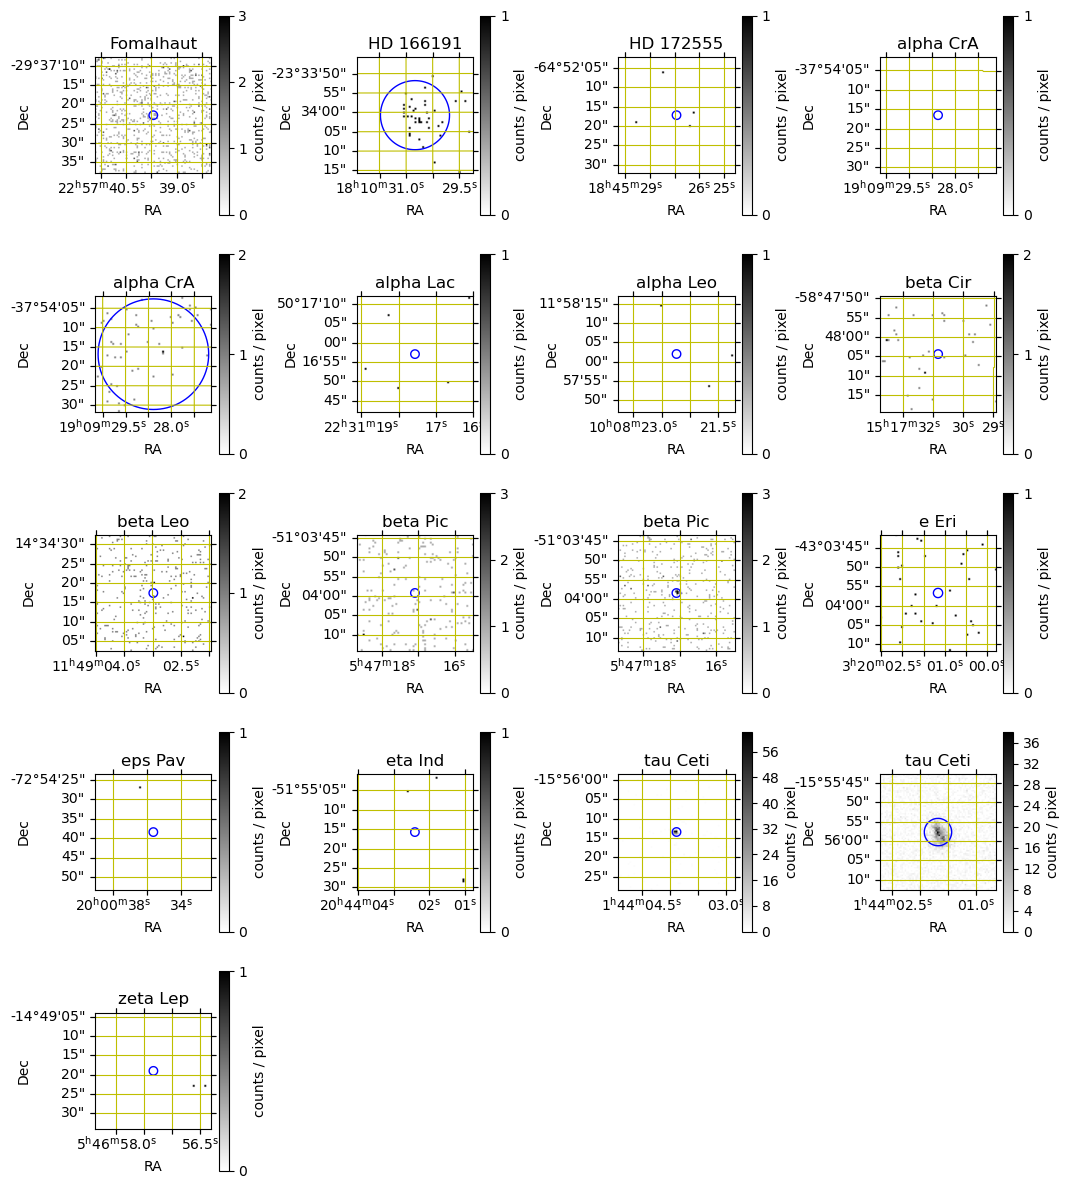

In [38]:
fig = plt.figure(figsize=(12, 15))
for i, target in enumerate(imageing_obs):
    obsid = target['ObsId']
    coord = target['coord']
    hdu = fits.open(f'data/A_stars/{obsid}_imcenter.fits')[0]
    wcs = WCS(hdu.header)
    ax = fig.add_subplot(5, 4, i+1, projection=wcs)
    im = ax.imshow(hdu.data, origin='lower', cmap=plt.get_cmap('binary'), 
                   # Ensure that the color bar spans at least 0..1 even if there are no counts
                   vmin=0, vmax = max(1, hdu.data.max()))
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('counts / pixel')
    # Since counts are integer values, we want to label only the integers
    cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(color='y', ls='solid')
    r = SphericalCircle((coord.ra, coord.dec), target['psf_90'] * u.arcsec,
                         edgecolor='b', facecolor='none',
                         transform=ax.get_transform('fk5'))
    ax.add_patch(r)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['ra'].set_ticklabel(exclude_overlapping=True)
    # minpad moved the label "Dec". A negative value moves it in a little bit.
    ax.coords['dec'].set_axislabel('Dec', minpad=-1)
    ax.set_title(target['object'])

fig.subplots_adjust(wspace=.8)
#fig.savefig('chandra.pdf', bbox_inches='tight')

The size of the blue circle is the 90% PSF at 2.3 keV (but the PSF does not strongly change with energy). For ACIS photons are filtered to 1.0-6.0 keV.

The tau Ceti HRC-S observation is taken in the special dither mode to dither the source on and off the different filter thickness. Standard processing can only give a count number, but that's not very helpful. This will need special processing if we want to use it. It's a relatively new observation by Steeve Saar that became public just a few months ago, and there is no publication about it yet.

I suggest that we contact Steeve and ask for the status and his plans. Maybe he has a publication in progress; then we could just take his number and cite him. Or, we could ask him to do the analysis and join this publication if he thinks a stand-alone article is not warrented. Either way, I would not have to deal with this unusual setup. (I can, but if he's doing that anyway, why should I dublicate the work?). 

For the publication, I should just remake this figure without the tau Ceti HRC observation, I would also change the labels to use greek letters etc.

#### Backgrounds
I originally tried to make background regions automatically using a large annulus and subtracting any known sources. However, I found that that is easier said than done due to a number of complications: If a source is on the edge of a chip, the background region might overlap with another chip, which is a problem if one is an FI and other other a BI chip. Also, for the non-detections, I'd like to just use `dmextract`` to get the count numbers - but `dmextract`` does not know about regions dithering on and off a chip etc. `specextract` *does* make a proper ARF, but then I have to deal with energy-dependent calculations and that's a lot more effort than warranted for weak undetected sources where I don't know the spectrum that I do not detect.

In [39]:
# Make a ds9 command line that I can copy and paste to see all ObsIDs I want to find background regions for
print('ds9 -log -cmap heat ', ' '.join([f'data/A_stars/{o}/primary/*evt2*' for o in imageing_obs['ObsId']]), '&')
    

ds9 -log -cmap heat  data/A_stars/17896/primary/*evt2* data/A_stars/12546/primary/*evt2* data/A_stars/5180/primary/*evt2* data/A_stars/5181/primary/*evt2* data/A_stars/7584/primary/*evt2* data/A_stars/5184/primary/*evt2* data/A_stars/5188/primary/*evt2* data/A_stars/628/primary/*evt2* data/A_stars/18931/primary/*evt2* data/A_stars/2537/primary/*evt2* data/A_stars/13626/primary/*evt2* data/A_stars/22292/primary/*evt2* data/A_stars/5182/primary/*evt2* data/A_stars/5183/primary/*evt2* data/A_stars/1886/primary/*evt2* data/A_stars/21194/primary/*evt2* data/A_stars/5187/primary/*evt2* &


In [45]:
# Print out a table that makes it easy to me to see where I am in Ds9 to select a proper background region
for row in imageing_obs:
    print(f"{row['ObsId']:6g} - {row['object']}: {row['coord'].ra.to_string(precision=1, sep=':', unit=u.hourangle):>12s}" + 
          f" {row['coord'].dec.to_string(precision=1, sep=':', alwayssign=True):15s}")

 17896 - Fomalhaut:   22:57:39.5 -29:37:22.8    
 12546 - HD 166191:   18:10:30.3 -23:34:00.7    
  5180 - HD 172555:   18:45:26.9 -64:52:17.2    
  5181 - alpha CrA:   19:09:28.4 -37:54:16.5    
  7584 - alpha CrA:   19:09:28.4 -37:54:16.8    
  5184 - alpha Lac:   22:31:17.6 +50:16:57.0    
  5188 - alpha Leo:   10:08:22.2 +11:58:02.0    
   628 - beta Cir:   15:17:30.8 -58:48:04.4    
 18931 - beta Leo:   11:49:03.0 +14:34:17.4    
  2537 - beta Pic:    5:47:17.1 -51:03:59.2    
 13626 - beta Pic:    5:47:17.1 -51:03:58.5    
 22292 - e Eri:    3:20:01.2 -43:03:56.7    
  5182 - eps Pav:   20:00:35.6 -72:54:38.4    
  5183 - eta Ind:   20:44:02.4 -51:55:15.7    
  1886 - tau Ceti:    1:44:03.9 -15:56:13.5    
 21194 - tau Ceti:    1:44:01.7 -15:55:57.7    
  5187 - zeta Lep:    5:46:57.3 -14:49:19.0    


In [53]:
# Selecting large, apparently source-free regions on the same chip (with one exception, where I used a different chip)
bkg_by_hand = {
    (5187, 'zeta Lep'): 'circle(4586.5,4178.5,298.43373)', # src detected in src detection
    (21194, 'tau Ceti'): 'circle(31978.479,31183.046,485.59334)',
    (1886, 'tau Ceti'): 'box(4260.1117,3912.0912,18.979063,232.20304,22.000013)', # Box at edge of detector, just like source
    # 1886: 'circle(4164.8519,3971.1435,39.793504)', # alternative: well-exposed circle in center of chip
    (5183, 'eta Ind'): 'circle(4090.7407,3643.963,226.13636)',
    (5182, 'eps Pav'): 'circle(4684.1,4108.1,259.25028)',
    (22292, 'e Eri'): 'circle(4217.1728,4343.0216,160.19905)',
    (13626, 'beta Pic'): 'circle(17521.22,16720.58,569.73078)',
    (2537, 'beta Pic'): 'circle(4298,4177,133.88501)',
    (18931, 'beta Leo'): 'circle(17264.324,17112.26,734.97317)',
    (628, 'beta Cir'): 'circle(4114.3611,4097.6944,58.774439)',
    (5188, 'alpha Leo'):'circle(3570.7222,4276.7407,287.56858)',
    (5184, 'alpha Lac'): 'circle(4495.1667,4135.1667,238.81769)',
    
    # Close to a node boundary which does something wired. PSF is large enough that source overlaps that region
    # So, I'm picking a wide box that covers the same boundary.
    (7584, 'alpha CrA'):'box(4810.5007,3005.5006,461.99996,72.00006,28.897914)', 
    
    (5181, 'alpha CrA'): 'circle(4561.6111,3633.8333,296.86925)',
    (5180, 'HD 172555'): 'circle(4521.1667,3375.8333,216.34624)', # there are several source ins the field, but this should work
    
    (17896, 'Fomalhaut'): 'circle(15327.685,17299.907,1045.7295)',
    
    (12546, 'HD 166191'): 'circle(3331.9,4319.1,172.10644)', # Exactly on edge of detector, dithers in and out. will use ARF or exposure map.
    # Either way, special treatment needed.
    # Also, dense cluster of sources, using bkg region on other ACIS-I chip at similar region from 
    # the center of IC 1274 which has a large number of X-ray sources. Some of those might be unresolved
    # but contribute to a background.
    
    
}

In [54]:
for target in imageing_obs:
    chandra_helpers.specextract('data/A_stars', target, bkg_by_hand)

specextract for ObsID 17896
specextract for ObsID 12546
specextract for ObsID 5180
specextract for ObsID 5181
specextract for ObsID 7584
specextract for ObsID 5184
specextract for ObsID 5188
specextract for ObsID 628
specextract for ObsID 18931
specextract for ObsID 2537
specextract for ObsID 13626
specextract for ObsID 22292
specextract for ObsID 5182
specextract for ObsID 5183
specextract for ObsID 1886
specextract for ObsID 21194
specextract for ObsID 5187


In [55]:
tabs = [chandra_helpers.dmextract_tab_and_lc('data/A_stars', target, bkg_by_hand)
        for target in imageing_obs]

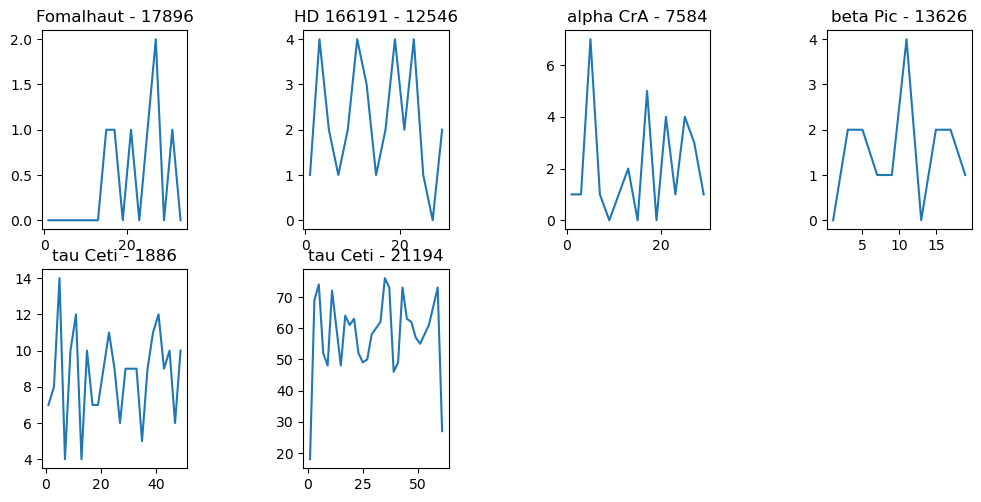

In [63]:
fig = plt.figure(figsize=(12, 15))
i = 0
for target in imageing_obs[:-1]:
    
    lcfile = f'data/A_stars/{target["ObsId"]}/lc_{target["object"].replace(" ", "_")}.fits'
    lc = table.Table.read(lcfile, hdu=1)
    if lc['COUNTS'].sum() > 3:
        ax = fig.add_subplot(5, 4, i+1)
        ax.plot((lc['TIME'][:-1] - lc['TIME_MIN'][0]) / 1e3, 
                lc['COUNTS'][:-1])
        ax.set_title(f"{target['object']} - {target['ObsId']}")
        i += 1

fig.subplots_adjust(wspace=.8)

1886 has a lot of optical loading (~700 counts). The Chandra calibration pages discuss a UV leak (using VEGA) and an optical/IR leak (using Betelgeuze). The limiting magnitudes given from those investigations are in the range -1 to -3 (depending on the band). Tau Ceti is bright, but not that bright; so for Tau Ceti we shoud lbe good and we can extract and fit the spectrum normally.

In [65]:
tabs = table.vstack(tabs, metadata_conflicts='silent')
imageing_obs_obs = table.hstack([imageing_obs_obs, tabs])


In [67]:
chandra_helpers.run_ap_limits(imageing_obs)
imageing_obs['AREA'].format = '{:.1f}'
imageing_obs['BG_AREA'].format = '{:.0f}'
imageing_obs['Upper limit'].format = '{:.1e}'
for col in ['COUNTS', 'BG_COUNTS']:
    imageing_obs[col] = imageing_obs[col].astype(int)

In [70]:
for target in imageing_obs:
    ui.load_data(f'{target["ObsId"]} - {target["object"]}', 
                 f'data/A_stars/{target["ObsId"]}/spec_{target["object"].replace(" ", "_")}.pi')

read ARF file data/A_stars/17896/spec_Fomalhaut.corr.arf


read RMF file data/A_stars/17896/spec_Fomalhaut.rmf
read ARF (background) file data/A_stars/17896/spec_Fomalhaut.corr.arf
read RMF (background) file data/A_stars/17896/spec_Fomalhaut.rmf
read background file data/A_stars/17896/spec_Fomalhaut_bkg.pi
read ARF file data/A_stars/12546/spec_HD_166191.corr.arf
read RMF file data/A_stars/12546/spec_HD_166191.rmf
read ARF (background) file data/A_stars/12546/spec_HD_166191.corr.arf
read RMF (background) file data/A_stars/12546/spec_HD_166191.rmf
read background file data/A_stars/12546/spec_HD_166191_bkg.pi
read ARF file data/A_stars/5180/spec_HD_172555.corr.arf
read RMF file data/A_stars/5180/spec_HD_172555.rmf
read ARF (background) file data/A_stars/5180/spec_HD_172555.corr.arf
read RMF (background) file data/A_stars/5180/spec_HD_172555.rmf
read background file data/A_stars/5180/spec_HD_172555_bkg.pi
read ARF file data/A_stars/5181/spec_alpha_CrA.corr.arf
read RMF file data/A_stars/5181/spec_alpha_CrA.rmf
read ARF (background) file data/A_sta

In [71]:
ui.set_analysis('energy')

dataset 12546 - HD 166191: 0.0073:14.9504 Energy (keV)
dataset 13626 - beta Pic: 0.06:10 Energy (keV)
dataset 17896 - Fomalhaut: 0.06:10 Energy (keV)
dataset 1886 - tau Ceti: 0.0073:14.9504 Energy (keV)
dataset 18931 - beta Leo: 0.06:10 Energy (keV)
dataset 21194 - tau Ceti: 0.06:10 Energy (keV)
dataset 22292 - e Eri: 0.0073:14.9504 Energy (keV)
dataset 2537 - beta Pic: 0.0073:14.9504 Energy (keV)
dataset 5180 - HD 172555: 0.0073:14.9504 Energy (keV)
dataset 5181 - alpha CrA: 0.0073:14.9504 Energy (keV)
dataset 5182 - eps Pav: 0.0073:14.9504 Energy (keV)
dataset 5183 - eta Ind: 0.0073:14.9504 Energy (keV)
dataset 5184 - alpha Lac: 0.0073:14.9504 Energy (keV)
dataset 5187 - zeta Lep: 0.0073:14.9504 Energy (keV)
dataset 5188 - alpha Leo: 0.0073:14.9504 Energy (keV)
dataset 628 - beta Cir: 0.0073:14.9504 Energy (keV)
dataset 7584 - alpha CrA: 0.0073:14.9504 Energy (keV)


dataset 17896 - Fomalhaut: 0.102712:6.98843 Energy (keV) (unchanged)
dataset 17896 - Fomalhaut: 0.102712:6.98843 Energy (keV) (unchanged)
dataset 17896 - Fomalhaut: 0.102712:6.98843 Energy (keV) (unchanged)
Dataset               = 17896 - Fomalhaut
Method                = levmar
Statistic             = cash
Initial fit statistic = 805.905
Final fit statistic   = 805.905 at function evaluation 45
Data points           = 4
Degrees of freedom    = 3
Change in statistic   = 0
   17896_-_Fomalhaut.norm   0            +/- 4.91454e-06 
Method                = levmar
Statistic             = cash
Initial fit statistic = 805.905
Final fit statistic   = 805.905 at function evaluation 45
Data points           = 4
Degrees of freedom    = 3
Change in statistic   = 0
   17896_-_Fomalhaut.norm   0            +/- 4.91454e-06 
Method                = levmar
Statistic             = cash
Initial fit statistic = 805.905
Final fit statistic   = 805.905 at function evaluation 45
Data points           = 4
Deg

/Users/guenther/mambaforge/envs/ciao-4.16/lib/python3.11/site-packages/sherpa/plot/pylab_backend.py:128: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.draw()


22292_-_e_Eri.norm lower bound:	-----
22292_-_e_Eri.norm upper bound:	2.30469e-07
dataset 5182 - eps Pav: 0.4088:6.9934 Energy (keV) (unchanged)
dataset 5182 - eps Pav: 0.4088:6.9934 Energy (keV) (unchanged)
dataset 5183 - eta Ind: 0.4088:6.9934 Energy (keV) (unchanged)
dataset 5183 - eta Ind: 0.4088:6.9934 Energy (keV) (unchanged)
dataset 1886 - tau Ceti: 0.4088:6.9934 Energy (keV) (unchanged)
dataset 1886 - tau Ceti: 0.4088:6.9934 Energy (keV) (unchanged)
dataset 1886 - tau Ceti: 0.4088:6.9934 Energy (keV) (unchanged)
Dataset               = 1886 - tau Ceti
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 2.13833e+13
Final fit statistic   = 4.05606 at function evaluation 429
Data points           = 7
Degrees of freedom    = 3
Probability [Q-value] = 0.255474
Reduced statistic     = 1.35202
Change in statistic   = 2.13833e+13
   1886_-_tau_Ceti_1.kT   0.148034     +/- 0.0118663   
   1886_-_tau_Ceti_1.norm   1.27045e-05  +/- 2.86294e-06 
   18

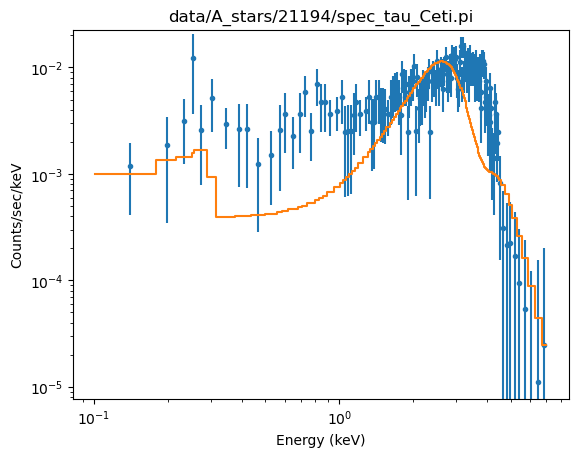

In [86]:
# This is copied from the other notebook and not put into a function,
# because I hand-select the starting values for the model parameters
# and the model parameters for low-count spectra.

imageing_obs['flux'] = 0.
imageing_obs['fluxlow'] = 0.
imageing_obs['fluxhigh'] = 0.
for f in ['flux', 'fluxlow', 'fluxhigh']:
    imageing_obs[f].format = '{:.1e}'

for target in imageing_obs:
    idname = f'{target["ObsId"]} - {target["object"]}'
    if target['Instrument'].startswith('ACIS'):
        ui.ignore_id(idname, None, 0.4)
    else:
        ui.ignore_id(idname, None, 0.1)
    ui.ignore_id(idname, 7, None)
    counts = ui.get_data(idname).counts.sum()
    
    # make sure both references exist
    ui.set_source(idname, ui.xsapec.a1 + ui.xsapec.a2)
    
    if (counts > 500) and target['Instrument'].startswith('ACIS'):
        ui.set_stat("chi2gehrels")
        model = ui.xsapec(name=idname.replace(" ", "_")+'_1') + ui.xsapec(name=idname.replace(" ", "_")+ '_2')
        model.lhs.kT = 0.5
        model.rhs.kT = 1.
        ui.set_source(idname, model)
        ui.group_counts(idname, 15)
        ui.subtract(idname)
    
    elif counts > 50:
        ui.set_stat("chi2gehrels")
        model = ui.xsapec(name=idname.replace(" ", "_"))
        ui.set_source(idname, model)
        ui.group_counts(idname, 5)
        ui.subtract(idname)
    elif counts > 5:
        model = ui.xsapec(name=idname.replace(" ", "_"))
        ui.set_stat("cash")
        ui.unsubtract(idname)
        ui.set_source(idname, model)
        ui.group_counts(idname, 2)
        model.kT = 0.5
        model.kT.frozen = True
    else:
        continue
    if target['Instrument'].startswith('HRC'):
        model.kT = 0.5
        model.kT.frozen = True
    
    ui.fit(idname)
    ui.plot_fit(idname, xlog=True, ylog=True)
    cvals = ui.sample_energy_flux(0.4, 7, num=1000, id=idname, 
                                      model=ui.get_source(idname))
    flow, f, fhigh = np.percentile(cvals[:, 0], [5, 50, 95])
    target['flux'] = f
    target['fluxlow'] = flow
    target['fluxhigh'] = fhigh

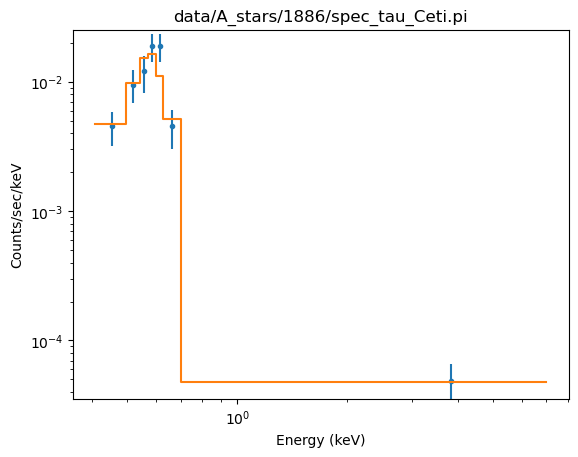

In [89]:
ui.plot_fit('1886 - tau Ceti', xlog=True, ylog=True)

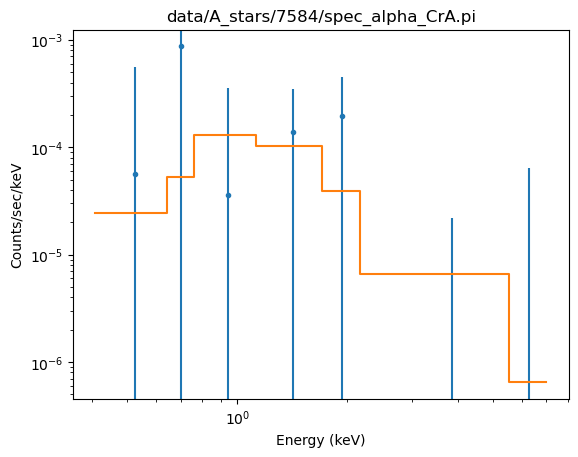

In [88]:
ui.plot_fit('7584 - alpha CrA', xlog=True, ylog=True)

Dataset               = 12546
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 5.10087e+09
Final fit statistic   = 3.41374 at function evaluation 37
Data points           = 7
Degrees of freedom    = 5
Probability [Q-value] = 0.636479
Reduced statistic     = 0.682747
Change in statistic   = 5.10087e+09
   a12546.kT      1.28927      +/- 0.408304    
   a12546.norm    4.52976e-05  +/- 2.96915e-05 


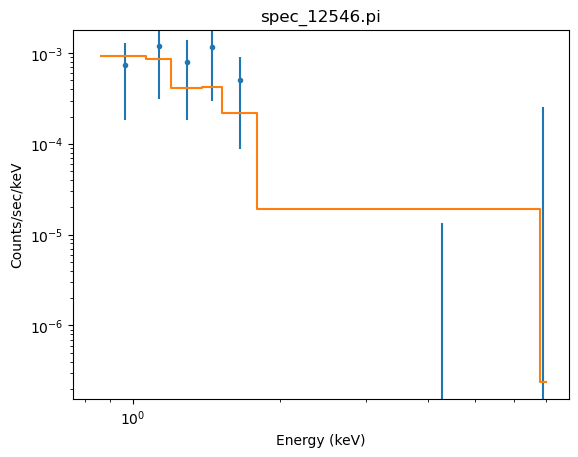

In [ ]:
ui.plot_fit('12546 - HD 166191', xlog=True, ylog=True)

In [92]:
model = ui.xsapec(name='model')
model.kT = 0.5
model.norm = 1e-3

for kT in [0.15, .5, 1.]:
    model.kT = kT
    imageing_obs[f'limit_{kT}'] = [model_helpers.count_rate_to_flux(f'{target["ObsId"]} - {target["object"]}', 
                                                                   model, row['Upper limit'], lo=0.4, hi=7.) for row in imageing_obs]
    imageing_obs[f'limit_{kT}'].format = '{:.1e}'

In [93]:
undetected = chandra_obs['COUNTS'] <= chandra_obs['Detection threshold']
for col in ['flux', 'fluxlow', 'fluxhigh']:
    chandra_obs[col][undetected] = np.nan

In [94]:
not_fitted = imageing_obs['flux'] == 0.

scale = imageing_obs['COUNTS'][not_fitted] / imageing_obs['Detection threshold'][not_fitted]
imageing_obs['flux'][not_fitted] = imageing_obs['limit_0.5'][not_fitted] * scale
imageing_obs['fluxhigh'][not_fitted] = imageing_obs['flux'][not_fitted] * (1 + np.sqrt(1 / imageing_obs['COUNTS'][not_fitted]))
imageing_obs['fluxlow'][not_fitted] = imageing_obs['flux'][not_fitted] * (1 - np.sqrt(1 / imageing_obs['COUNTS'][not_fitted]))


In [97]:
imageing_obs['object', 'ObsId', 'Instrument', 'Exposure',
            'COUNTS', 'BG_COUNTS', 'BG_AREA', 'AREA', 'Detection threshold', 'Upper limit',
            'flux', 'fluxlow', 'fluxhigh', 
            'limit_0.15', 'limit_0.5', 'limit_1.0']

object,ObsId,Instrument,Exposure,COUNTS,BG_COUNTS,BG_AREA,AREA,Detection threshold,Upper limit,flux,fluxlow,fluxhigh,limit_0.15,limit_0.5,limit_1.0
,,,,ct,ct,pix2,pix2,,ct / s,,,,erg / (s cm2),erg / (s cm2),erg / (s cm2)
str9,int64,str6,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
Fomalhaut,17896,HRC-I,32.69,7,56506,3435489,217.9,6,9.4e-05,6.3e-15,0.0e+00,1.6e-13,2.1e-15,7.0e-16,6.1e-16
HD 166191,12546,ACIS-I,29.68,33,674,93056,1032.3,11,1.4e-04,2.9e-13,2.1e-13,3.7e-13,3.1e-15,1.1e-15,9.2e-16
HD 172555,5180,ACIS-I,2.94,0,63,147044,15.6,0,2.3e-04,nan,nan,nan,5.1e-15,1.8e-15,1.4e-15
alpha CrA,5181,ACIS-I,3.14,0,134,276873,15.5,0,2.2e-04,nan,nan,nan,4.8e-15,1.7e-15,1.4e-15
alpha CrA,7584,ACIS-S,29.66,31,295,33264,2645.0,30,2.4e-04,2.3e-15,0.0e+00,1.0e-14,5.4e-15,1.9e-15,1.6e-15
alpha Lac,5184,ACIS-I,2.98,0,77,179177,15.6,0,2.3e-04,nan,nan,nan,5.1e-15,1.7e-15,1.5e-15
alpha Leo,5188,ACIS-I,3.1,0,154,259796,15.5,0,2.2e-04,nan,nan,nan,4.9e-15,1.7e-15,1.4e-15
beta Cir,628,ACIS-S,19.05,0,79,10852,15.7,1,8.2e-05,0.0e+00,nan,nan,1.8e-15,6.3e-16,5.3e-16
